In [5]:
!pip install torch torchvision torchaudio

  Using cached torch-2.10.0-cp310-cp310-win_amd64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp310-cp310-win_amd64.whl.metadata (5.4 kB)
  Using cached torchaudio-2.10.0-cp310-cp310-win_amd64.whl.metadata (6.9 kB)
Using cached torch-2.10.0-cp310-cp310-win_amd64.whl (113.7 MB)
Using cached torchvision-0.25.0-cp310-cp310-win_amd64.whl (3.7 MB)
Using cached torchaudio-2.10.0-cp310-cp310-win_amd64.whl (474 kB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   --------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import os
from tqdm import tqdm
import glob 
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## MediaPipe, normalization and smoothing

In [23]:
class TennisSkeletonExtractor:

    # initialization the MediaPipe Pose model
    def __init__(self, min_detection_confidence=0.5, min_tracking_confidence=0.5):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,       # optimized for video stream
            model_complexity=2,            # highest accuracy model
            smooth_landmarks=True,         # reduce jitter internally
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=min_tracking_confidence
        )

    #  feature Extraction from a video file frame by frame with Sanity Check 
    def get_landmarks(self, video_path, jump_threshold=0.15):

        cap = cv2.VideoCapture(video_path)
        landmarks_data = []
        
        # variable to store the players position in the previous frame
        prev_hip_center = None 
        
        while cap.isOpened():
            success, image = cap.read()
            
            #stop if video ends or frame is empty
            if not success or image is None:
                break
            
            try:
                # convert BGR to RGB 
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except cv2.error:
                continue

            # process the frame to find pose landmarks
            results = self.pose.process(image_rgb)
            
            frame_landmarks = []
            is_valid_frame = False
            
            if results.pose_landmarks:
                # extract landmarks into a flat list
                temp_landmarks = []
                for landmark in results.pose_landmarks.landmark:
                    temp_landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                
                # calculate current hip center
                idx_l = 23 * 4 
                idx_r = 24 * 4  
                
                cx = (temp_landmarks[idx_l] + temp_landmarks[idx_r]) / 2
                cy = (temp_landmarks[idx_l+1] + temp_landmarks[idx_r+1]) / 2
                current_center = np.array([cx, cy])
                
                # compare distance to previous frame
                if prev_hip_center is not None:
                    dist = np.linalg.norm(current_center - prev_hip_center)
                    
                    # if movement is smaller than threshold, valid 
                    if dist < jump_threshold:
                        frame_landmarks = temp_landmarks
                        prev_hip_center = current_center
                        is_valid_frame = True
                    else:
                        # else, not
                        is_valid_frame = False 
                else:
                    # first frame is always valid
                    frame_landmarks = temp_landmarks
                    prev_hip_center = current_center
                    is_valid_frame = True
            
            # append landmarks if valid, otherwise append NaN
            if is_valid_frame:
                landmarks_data.append(frame_landmarks)
            else:
                landmarks_data.append([np.nan] * (33 * 4))
                
        cap.release()
        
        cols = []
        for i in range(33):
            cols.extend([f'x_{i}', f'y_{i}', f'z_{i}', f'v_{i}'])
            
        return pd.DataFrame(landmarks_data, columns=cols)

    # normalization
    def normalize_skeleton(self, df):

        # calculate Hip center
        hip_x = (df['x_23'] + df['x_24']) / 2
        hip_y = (df['y_23'] + df['y_24']) / 2
        
        # calculate torso size
        sh_x = (df['x_11'] + df['x_12']) / 2
        sh_y = (df['y_11'] + df['y_12']) / 2
        
        # distance
        torso_size = np.sqrt((sh_x - hip_x)**2 + (sh_y - hip_y)**2)
        torso_size = torso_size.replace(0, 1.0) # avoid division by zero

        # apply to all landmarks
        norm_df = df.copy()
        for i in range(33):
            norm_df[f'x_{i}'] = (df[f'x_{i}'] - hip_x) / torso_size
            norm_df[f'y_{i}'] = (df[f'y_{i}'] - hip_y) / torso_size
            
        return norm_df

    # smoothing jittery movements
    def smooth_data(self, df, window=5, poly=3):
        
        # fix NaNs from sanity check
        df_filled = df.interpolate(method='linear', limit_direction='both')
        
        # apply smoothing filter
        smoothed = df_filled.copy()
        for col in df_filled.columns:
            try:
                smoothed[col] = savgol_filter(df_filled[col], window, poly)
            except ValueError:
                # if video is too short for the filter window, skip smoothing
                pass
                
        return smoothed

### Main Processing Loop

In [32]:

base_path = r'C:\Users\Noam\OneDrive\Desktop\DL_project\dataset\VIDEO_RGB'
output_base = r'C:\Users\Noam\OneDrive\Desktop\DL_project\dataset\PROCESSED_DATA'

if not os.path.exists(output_base):
    os.makedirs(output_base)
    print(f"Created output directory: {output_base}")

extractor = TennisSkeletonExtractor()


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(f"Found {len(classes)} classes: {classes}")

# iterate over each class folder
for class_name in classes:
    class_input_dir = os.path.join(base_path, class_name)
    class_output_dir = os.path.join(output_base, class_name)
    
    # create class output folder
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)
        
    # list of video files
    videos = [f for f in os.listdir(class_input_dir) if f.endswith(('.avi', '.mp4'))]
    print(f"\nProcessing class: {class_name} ({len(videos)} videos)...")
    
    for video_file in tqdm(videos):
        video_path = os.path.join(class_input_dir, video_file)
        save_path = os.path.join(class_output_dir, video_file.replace('.avi', '.csv').replace('.mp4', '.csv'))
        
        if os.path.exists(save_path):
            continue
            
        try:
            # extract raw landmarks
            raw_df = extractor.get_landmarks(video_path)
            
            # skip empty videos or failed extractions
            if raw_df.empty:
                continue 

            # normalizetion
            norm_df = extractor.normalize_skeleton(raw_df)
            
            #  smoothing
            clean_df = extractor.smooth_data(norm_df)
            
            # save to CSV
            clean_df.to_csv(save_path, index=False)
            
        except Exception as e:
            print(f"Error processing {video_file}: {e}")

print("\n--- Full Dataset Processing Complete! ---")

Created output directory: C:\Users\Noam\OneDrive\Desktop\DL_project\dataset\PROCESSED_DATA
Found 12 classes: ['backhand', 'backhand2hands', 'backhand_slice', 'backhand_volley', 'flat_service', 'forehand_flat', 'forehand_openstands', 'forehand_slice', 'forehand_volley', 'kick_service', 'slice_service', 'smash']

Processing class: backhand (165 videos)...


100%|██████████| 165/165 [18:22<00:00,  6.68s/it]



Processing class: backhand2hands (165 videos)...


100%|██████████| 165/165 [19:16<00:00,  7.01s/it]



Processing class: backhand_slice (165 videos)...


100%|██████████| 165/165 [17:41<00:00,  6.43s/it]



Processing class: backhand_volley (165 videos)...


100%|██████████| 165/165 [16:55<00:00,  6.15s/it]



Processing class: flat_service (165 videos)...


100%|██████████| 165/165 [19:56<00:00,  7.25s/it]



Processing class: forehand_flat (165 videos)...


100%|██████████| 165/165 [18:56<00:00,  6.89s/it]



Processing class: forehand_openstands (165 videos)...


100%|██████████| 165/165 [16:39<00:00,  6.06s/it]



Processing class: forehand_slice (165 videos)...


100%|██████████| 165/165 [17:08<00:00,  6.23s/it]



Processing class: forehand_volley (165 videos)...


100%|██████████| 165/165 [15:43<00:00,  5.72s/it]



Processing class: kick_service (165 videos)...


100%|██████████| 165/165 [19:58<00:00,  7.26s/it]



Processing class: slice_service (165 videos)...


100%|██████████| 165/165 [18:41<00:00,  6.79s/it]



Processing class: smash (165 videos)...


100%|██████████| 165/165 [17:08<00:00,  6.23s/it]


--- Full Dataset Processing Complete! ---


## Data augmentation

### Mirroring the data

In [6]:

ROOT_DIR = r'C:\Users\Noam\OneDrive\Desktop\DL_project\dataset\PROCESSED_DATA'

# MediaPipe (left <->right)
POSE_PAIRS = [
    # face
    (1, 4), (2, 5), (3, 6), (7, 8), (9, 10),
    # torso
    (11, 12), (13, 14), (15, 16),
    # hands
    (17, 18), (19, 20), (21, 22),
    # pelvis
    (23, 24), (25, 26), (27, 28),
    # legs
    (29, 30), (31, 32)
]

def create_mirror_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        
        flipped_df = df.copy()

        for i in range(33):
            col_x = f'x_{i}'
            if col_x in df.columns:
                flipped_df[col_x] = 1.0 - df[col_x]

        for idx_a, idx_b in POSE_PAIRS:
            for params in ['x', 'y', 'z', 'v']:
                col_a = f'{params}_{idx_a}'
                col_b = f'{params}_{idx_b}'
                
                if col_a in df.columns and col_b in df.columns:
                    flipped_df[col_a] = df[col_b] 
                    flipped_df[col_b] = df[col_a] 

        # data.csv -> data_flipped.csv
        new_filename = file_path.replace('.csv', '_flipped.csv')
        flipped_df.to_csv(new_filename, index=False)
        print(f"Created: {os.path.basename(new_filename)}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if file.endswith(".csv") and "_flipped" not in file:
            full_path = os.path.join(root, file)
            create_mirror_csv(full_path)

print("Succeeded. Mirror augmentation complete.")

Created: p10_backhand_s1_flipped.csv
Created: p10_backhand_s2_flipped.csv
Created: p10_backhand_s3_flipped.csv
Created: p11_backhand_s1_flipped.csv
Created: p11_backhand_s2_flipped.csv
Created: p11_backhand_s3_flipped.csv
Created: p12_backhand_s1_flipped.csv
Created: p12_backhand_s2_flipped.csv
Created: p12_backhand_s3_flipped.csv
Created: p13_backhand_s1_flipped.csv
Created: p13_backhand_s2_flipped.csv
Created: p13_backhand_s3_flipped.csv
Created: p14_backhand_s1_flipped.csv
Created: p14_backhand_s2_flipped.csv
Created: p14_backhand_s3_flipped.csv
Created: p15_backhand_s1_flipped.csv
Created: p15_backhand_s2_flipped.csv
Created: p15_backhand_s3_flipped.csv
Created: p16_backhand_s1_flipped.csv
Created: p16_backhand_s2_flipped.csv
Created: p16_backhand_s3_flipped.csv
Created: p17_backhand_s1_flipped.csv
Created: p17_backhand_s2_flipped.csv
Created: p17_backhand_s3_flipped.csv
Created: p18_backhand_s1_flipped.csv
Created: p18_backhand_s2_flipped.csv
Created: p18_backhand_s3_flipped.csv
C

### Train/Test/validation split

#### to counter memory leakage, we need to make sure that the same video plus his fliped video in the same split

In [14]:
ROOT_DIR = r'C:\Users\Noam\OneDrive\Desktop\DL_project\dataset\PROCESSED_DATA'

def get_base_name(filename):
    # to prevent memory leakage
    name_without_ext = os.path.splitext(filename)[0]
    if name_without_ext.endswith('_flipped'):
        return name_without_ext.replace('_flipped', '')
    return name_without_ext


grouped_files = defaultdict(list)
file_labels = {} 

for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if file.endswith(".csv"):
            full_path = os.path.join(root, file)
            
            # folder name is the label
            label = os.path.basename(root)
            
            base_name = get_base_name(file)
            unique_id = f"{label}_{base_name}" # to prevent same name
            
            grouped_files[unique_id].append(full_path)
            file_labels[unique_id] = label

# split
all_unique_ids = list(grouped_files.keys())
all_labels = [file_labels[uid] for uid in all_unique_ids]

print(f"Total unique sequences found: {len(all_unique_ids)}")

# train/test/validation
train_ids, temp_ids, train_labels, temp_labels = train_test_split(
    all_unique_ids, all_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=all_labels # all of the classes in all of the splits
)

val_ids, test_ids, _, _ = train_test_split(
    temp_ids, temp_labels, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_labels
)

# return list
def flatten_file_list(id_list):
    final_files = []
    labels = []
    for uid in id_list:
        files = grouped_files[uid]
        final_files.extend(files)
        labels.extend([file_labels[uid]] * len(files))
    return final_files, labels

train_files, train_y = flatten_file_list(train_ids)
val_files, val_y = flatten_file_list(val_ids)
test_files, test_y = flatten_file_list(test_ids)

print(f"Train files: {len(train_files)}")
print(f"Val files:   {len(val_files)}")
print(f"Test files:  {len(test_files)}")

# example
print("Example Train File:", train_files[0])
print("Example Label:", train_y[0])

Total unique sequences found: 1980
Train files: 3168
Val files:   396
Test files:  396
Example Train File: C:\Users\Noam\OneDrive\Desktop\DL_project\dataset\PROCESSED_DATA\forehand_openstands\p22_foreopen_s2.csv
Example Label: forehand_openstands


## MODEL

### Dataset & padding

In [7]:
class TennisDataset(Dataset):
    def __init__(self, file_paths, labels, label_map):
        self.file_paths = file_paths  # list of paths to CSV
        self.labels = labels          # list of labels
        self.label_map = label_map    # dictionary mapping string labels to number IDs

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # load the CSV file
        path = self.file_paths[idx]
        df = pd.read_csv(path)
        
        # converting dataframe to tensor
        features = torch.tensor(df.values, dtype=torch.float32)
        
        # get the label ID
        label_str = self.labels[idx]
        label_id = self.label_map[label_str]
        
        return features, label_id

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    
    # calculate the actual length of each sequence before padding
    x_lens = [len(x) for x in xx]
    
    # padding
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    
    # convert labels and lengths to tensors
    yy = torch.tensor(yy)
    x_lens = torch.tensor(x_lens)
    
    return xx_pad, yy, x_lens

### model architecture

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Simple linear projection to calculate "importance" score per frame
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, gru_output, mask):
        # Calculate raw energy scores for every frame (including padding)
        # Shape: (Batch, Max_Len, 1)
        energy = self.attn(gru_output)
        
        # Remove the last dimension to get (Batch, Max_Len)
        energy = energy.squeeze(2)
        
        # This guarantees that the Attention Weight for padding will be exactly 0.0.
        energy = energy.masked_fill(mask == False, -1e9)
        
        # Calculate probabilities (Attention Weights)
        # The padding frames effectively disappear here.
        attn_weights = torch.softmax(energy, dim=1)
        
        # Calculate Context Vector (Weighted Sum)
        # (Batch, 1, Max_Len) @ (Batch, Max_Len, Hidden_Dim) -> (Batch, 1, Hidden_Dim)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), gru_output).squeeze(1)
        
        return context_vector, attn_weights

In [9]:
class TennisBiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, use_attention=True):
        super(TennisBiGRU, self).__init__()
        
        # Bi-Directional GRU.
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # attention layer (defined below)
        self.attention = Attention(hidden_dim * 2) 
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, x_lengths):
       
        # this prevents the GRU from "learning" that sequences end with zeros.
        x_packed = pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # run GRU
        packed_output, _ = self.gru(x_packed)
        
        # The output at padded positions will be strict zeros.
        gru_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # we create a boolean mask where True = Real Data, False = Padding.
        batch_size, max_len, _ = gru_output.size()
        mask = torch.arange(max_len, device=x.device).expand(batch_size, max_len) < x_lengths[:, None].to(x.device)
        
        # pass the output and the mask to the Attention mechanism
        context_vector, attn_weights = self.attention(gru_output, mask)
        
        # final classification
        output = self.fc(context_vector)
        
        return output, attn_weights

### training loop

In [10]:
def train_model(model, train_loader, val_loader, device, num_epochs=20, class_weights=None):
    # loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # store performance history
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_acc': []}
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train() 
        total_loss = 0
        
        for inputs, labels, lengths in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # forward pass
            outputs, _ = model(inputs, lengths)
            loss = criterion(outputs, labels)
            
            # gradient
            loss.backward()
            
            # update weights
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_train_loss = total_loss / len(train_loader)
        
        model.eval() 
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad(): # disable gradient calculation for efficiency
            for inputs, labels, lengths in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs, _ = model(inputs, lengths)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                #  predictions
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        
        # calculate Metrics 
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        
        # update Scheduler
        scheduler.step(avg_val_loss)
        
        # store stats
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {epoch_time:.1f}s | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Val F1: {val_f1:.4f}")
              
    return history

### execution

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
# create Label Map
unique_labels = sorted(list(set(all_labels)))
label_map = {label: i for i, label in enumerate(unique_labels)}
print(f"Labels: {label_map}")

# using the file lists from the train/test split 
train_dataset = TennisDataset(train_files, train_y, label_map)
val_dataset = TennisDataset(val_files, val_y, label_map)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, collate_fn=pad_collate)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, collate_fn=pad_collate)

INPUT_DIM = 132 #  132 features (33 points * 4 values)
OUTPUT_DIM = len(unique_labels) # Number of unique classes (12)
HIDDEN_DIM = 64 # size of the GRU memory

#  BASELINE MODEL 
print("   TRAINING BASELINE MODEL (Bi-GRU)")
# initialize model with use_attention=False
model_baseline = TennisBiGRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                             use_attention=False).to(device)

# train
history_baseline = train_model(model_baseline, train_loader, val_loader, 
                               device, num_epochs=20)


# ATTENTION MODEL
print("   TRAINING ATTENTION MODEL (Attn-GRU)   ")
# initialize model with use_attention=True
model_attention = TennisBiGRU(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                              use_attention=True).to(device)

# train
history_attention = train_model(model_attention, train_loader, val_loader, 
                                device, num_epochs=20)

Running on: cpu
Labels: {'backhand': 0, 'backhand2hands': 1, 'backhand_slice': 2, 'backhand_volley': 3, 'flat_service': 4, 'forehand_flat': 5, 'forehand_openstands': 6, 'forehand_slice': 7, 'forehand_volley': 8, 'kick_service': 9, 'slice_service': 10, 'smash': 11}
   TRAINING BASELINE MODEL (Bi-GRU)
Epoch [1/20] | Time: 174.9s | Train Loss: 2.0160 | Val Loss: 1.6632 | Val F1: 0.3690
Epoch [2/20] | Time: 75.7s | Train Loss: 1.4830 | Val Loss: 1.4649 | Val F1: 0.4240
Epoch [3/20] | Time: 72.4s | Train Loss: 1.2966 | Val Loss: 1.2894 | Val F1: 0.5060
Epoch [4/20] | Time: 62.8s | Train Loss: 1.1466 | Val Loss: 1.2383 | Val F1: 0.4936
Epoch [5/20] | Time: 67.0s | Train Loss: 1.0270 | Val Loss: 1.1033 | Val F1: 0.5827
Epoch [6/20] | Time: 67.6s | Train Loss: 0.9540 | Val Loss: 0.9697 | Val F1: 0.6046
Epoch [7/20] | Time: 64.7s | Train Loss: 0.8691 | Val Loss: 1.0069 | Val F1: 0.5951
Epoch [8/20] | Time: 64.7s | Train Loss: 0.8001 | Val Loss: 0.9557 | Val F1: 0.6253
Epoch [9/20] | Time: 64.6s

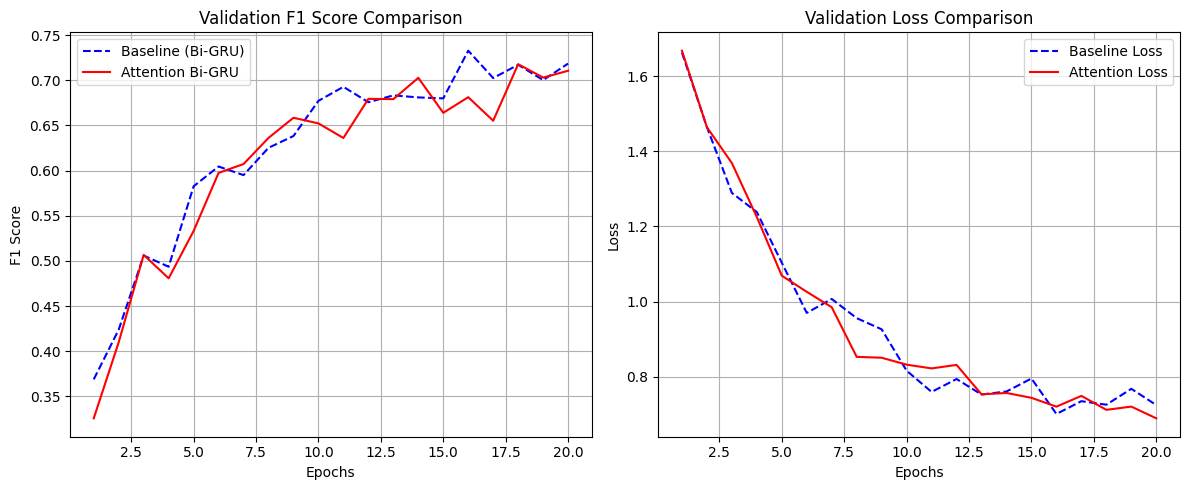

In [16]:
def plot_comparison(hist_base, hist_attn):
    epochs = range(1, len(hist_base['val_f1']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot F1 Score
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist_base['val_f1'], 'b--', label='Baseline (Bi-GRU)')
    plt.plot(epochs, hist_attn['val_f1'], 'r-', label='Attention Bi-GRU')
    plt.title('Validation F1 Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist_base['val_loss'], 'b--', label='Baseline Loss')
    plt.plot(epochs, hist_attn['val_loss'], 'r-', label='Attention Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the plot
plot_comparison(history_baseline, history_attention)

In [19]:
POSE_PAIRS = [
    (11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (11, 23), (12, 24), 
    (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), 
    (29, 31), (30, 32), (27, 31), (28, 32)
]

def create_skeleton_animation(model, dataset, idx, device):
    features, label_id = dataset[idx]
    id_to_label = {v: k for k, v in dataset.label_map.items()}
    label_str = id_to_label[label_id]
    
    input_tensor = features.unsqueeze(0).to(device)
    length_tensor = torch.tensor([len(features)])
    
    with torch.no_grad():
        output, attn_weights = model(input_tensor, length_tensor)
        
    weights = attn_weights.squeeze().cpu().numpy()
    seq_len = len(features)
    data = features.numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Skeleton Replay: {label_str}', fontsize=16)
    
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.invert_yaxis()
    ax1.set_title("Skeleton Movement")
    scatter, = ax1.plot([], [], 'ro', markersize=4)
    lines = [ax1.plot([], [], 'b-', linewidth=2)[0] for _ in range(len(POSE_PAIRS))]
    
    ax2.set_xlim(0, seq_len)
    ax2.set_ylim(0, max(weights) * 1.1)
    ax2.set_title("Live Attention Weight")
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("Importance")
    line_attn, = ax2.plot([], [], 'r-', linewidth=2)
    point_attn, = ax2.plot([], [], 'ro')
    
    def init():
        scatter.set_data([], [])
        for line in lines:
            line.set_data([], [])
        line_attn.set_data([], [])
        point_attn.set_data([], [])
        return scatter, line_attn, point_attn, *lines

    def update(frame):
        current_frame = data[frame]
        xs = []
        ys = []
        for i in range(33):
            xs.append(current_frame[i*4])
            ys.append(current_frame[i*4 + 1])
            
        scatter.set_data(xs, ys)
        for i, (start, end) in enumerate(POSE_PAIRS):
            x_line = [xs[start], xs[end]]
            y_line = [ys[start], ys[end]]
            lines[i].set_data(x_line, y_line)
            
        line_attn.set_data(range(frame), weights[:frame])
        point_attn.set_data([frame], [weights[frame]])
        return scatter, line_attn, point_attn, *lines

    ani = FuncAnimation(fig, update, frames=seq_len, init_func=init, blit=True, interval=50)
    plt.close()
    
    return HTML(ani.to_jshtml())

create_skeleton_animation(model_attention, val_dataset, 232, device)

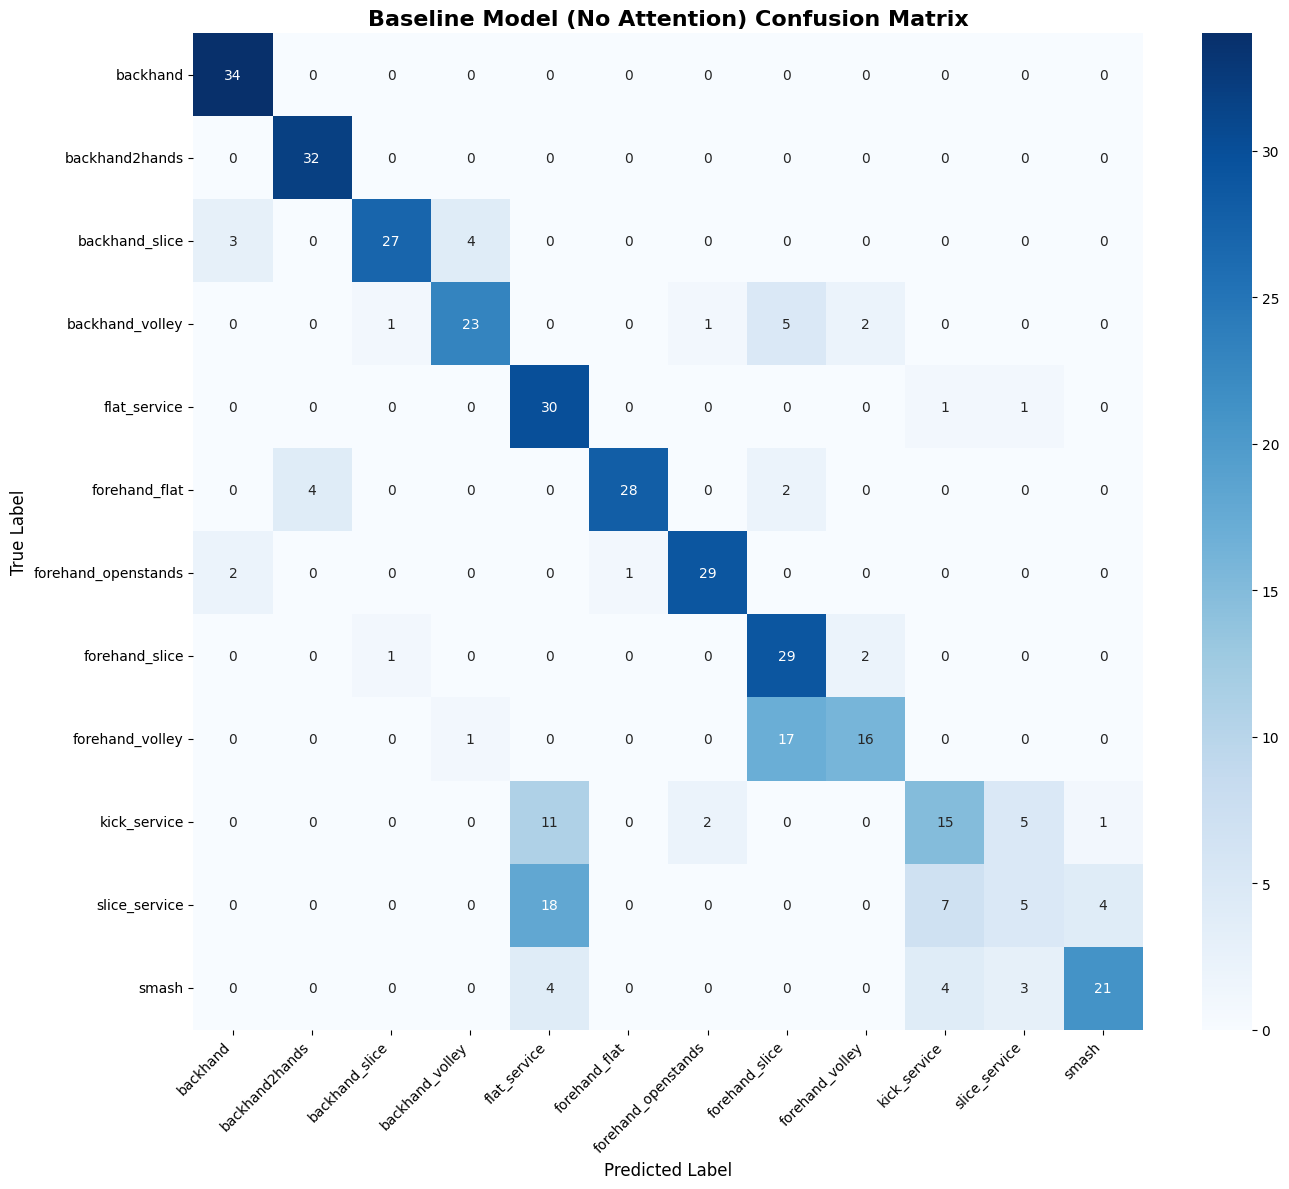

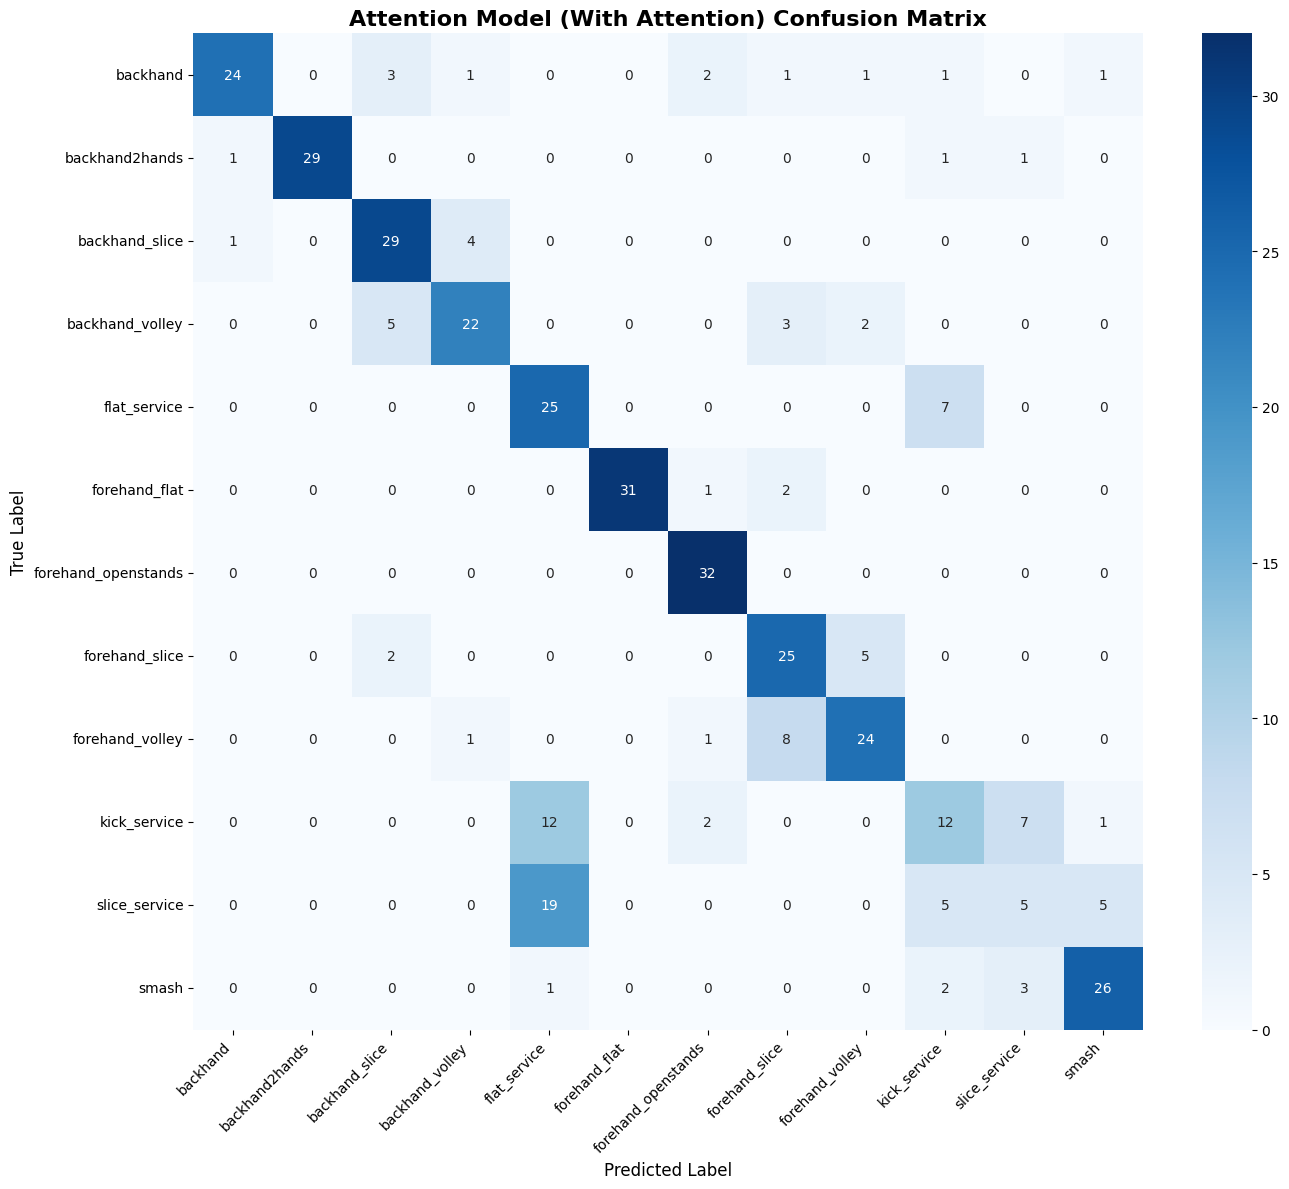

In [20]:
def plot_confusion_matrix(model, dataloader, device, label_map, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels, lengths in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs, lengths)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    id_to_label = {v: k for k, v in label_map.items()}
    class_names = [id_to_label[i] for i in range(len(label_map))]
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(14, 12)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(model_baseline, val_loader, device, label_map, 
                      title="Baseline Model (No Attention) Confusion Matrix")

plot_confusion_matrix(model_attention, val_loader, device, label_map, 
                      title="Attention Model (With Attention) Confusion Matrix")